# Imports and setup.

In [7]:
import logging

import matplotlib.pyplot as plt
import numpy as np

import algorithms
import loss_functions

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('ggplot')

logging.basicConfig(
    format = '%(asctime)s %(filename)s:%(lineno)d %(message)s',
    datefmt = '%I:%M:%S %p',
    level = logging.INFO
)

rng = np.random.default_rng()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set problem parameters.

In [52]:
m = 10
T = 200

# Create loss functions.

In [53]:
l_fn = loss_functions.create_rademacher_functions(T, m)

# Find the benchmark.

In [54]:
opt = algorithms.optimal_benchmark(
    l_fn,
    rng.random(size = 1),
    T,
    m
)
cum_loss_opt = np.cumsum([l_fn[t](opt.x) for t in range(T)])

06:42:44 PM algorithms.py:24 Optimal benchmark.
06:42:44 PM algorithms.py:33 	x: [-1.]
06:42:44 PM algorithms.py:34 	success: True
06:42:44 PM algorithms.py:35 	message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
06:42:44 PM algorithms.py:36 	fun: -632.4555320336758


# FTRL.

In [55]:
l_ftrl_res, l_cum_loss_alg = [], []

for mode in algorithms.mode_strs:

    init_fn = getattr(algorithms, f'ftrl_init_{mode}')
    z_0 = init_fn(m)

    eta = None
    eta = 1 / np.sqrt(T)

    l_ftrl_res.append(algorithms.ftrl(
        l_fn,
        z_0,
        T,
        m,
        eta,
        mode
    ))

    cum_loss_alg = np.cumsum([res.l for res in l_ftrl_res[-1]])
    l_cum_loss_alg.append(cum_loss_alg)

06:42:45 PM algorithms.py:61 mode 0: FTRL on f_t and project by taking the average.
06:42:49 PM algorithms.py:61 mode 1: FTRL on f_t and project onto the most recent decision.
06:42:54 PM algorithms.py:61 mode 2: FTRL on \circfn f_t.
06:42:55 PM algorithms.py:61 mode 3: FTRL on f_{1:t}((x, x_{t-1}, \dots, x_{t-m+1})).
06:42:55 PM algorithms.py:61 mode 4: FTRL on \circfn f_t plus \| (x, \dots, x) - (x, x_{t-1}, \dots, x_{t-m+1}) \|_2^2.


# Plot.

### Regret.

In [56]:
l_regret = [
    cum_loss_alg - cum_loss_opt for cum_loss_alg in l_cum_loss_alg
]

In [57]:
for (i, mode) in enumerate(algorithms.mode_strs):
    logging.info(f'Regret for mode {mode}: {l_regret[i][-1]}')

06:42:56 PM 3634568286.py:2 Regret for mode 0: 157.23710680000397
06:42:56 PM 3634568286.py:2 Regret for mode 1: 157.23708480039818
06:42:56 PM 3634568286.py:2 Regret for mode 2: 29.962826382702247
06:42:56 PM 3634568286.py:2 Regret for mode 3: 29.962826388991516
06:42:56 PM 3634568286.py:2 Regret for mode 4: 29.962826207869398


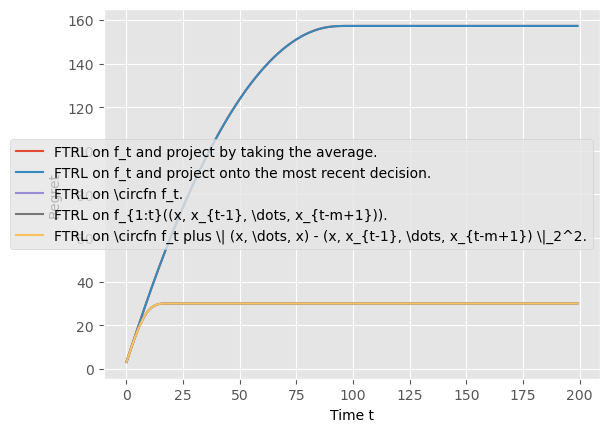

In [58]:
for (i, mode) in enumerate(algorithms.mode_strs):
    label = algorithms.mode_strs[mode]
    plt.plot(l_regret[i], label = label)
plt.xlabel('Time t')
plt.ylabel('Regret')
plt.legend()
plt.show()

### $\| h_t - (x_t, \dots, x_t) \|$.

In [59]:
l_diffs = []
for (i, mode) in enumerate(algorithms.mode_strs):

    diffs = []

    for t in range(T):

        h_t = [0] * max(0, m - t - 1) + \
            [l_ftrl_res[i][s].x for s in range(max(0, t - m + 1), t + 1)]
        x_t_history = [l_ftrl_res[i][t].x] * len(h_t)
        diff = np.linalg.norm(
            np.array(h_t) - np.array(x_t_history)
        )
        
        diffs.append(diff)

    diffs = np.array(diffs)
    l_diffs.append(diffs)

In [60]:
for (i, mode) in enumerate(algorithms.mode_strs):
    logging.info(
        f'Sum of norm differences between histories for mode {mode}: {np.sum(l_diffs[i])}'
    )

06:42:57 PM 969779365.py:2 Sum of norm differences between histories for mode 0: 16.950179436130025
06:42:57 PM 969779365.py:2 Sum of norm differences between histories for mode 1: 16.950178278545657
06:42:57 PM 969779365.py:2 Sum of norm differences between histories for mode 2: 17.58270689406582
06:42:57 PM 969779365.py:2 Sum of norm differences between histories for mode 3: 17.58270689976986
06:42:57 PM 969779365.py:2 Sum of norm differences between histories for mode 4: 17.582706916861014


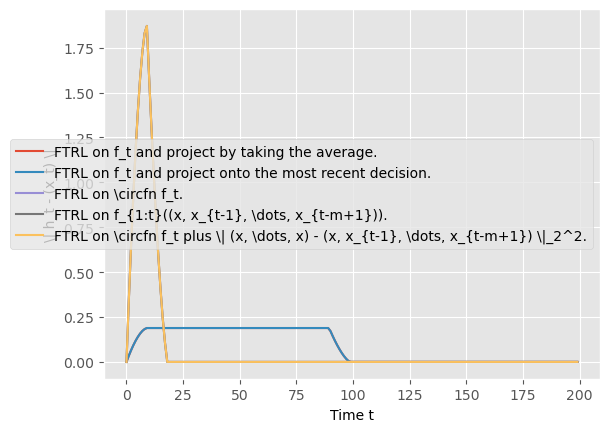

In [61]:
for (i, mode) in enumerate(algorithms.mode_strs):
    label = algorithms.mode_strs[mode]
    plt.plot(l_diffs[i], label = label)
plt.xlabel('Time t')
plt.ylabel('\| h_t - (x_t) \|')
plt.legend()
plt.show()

### $\| x_t^{(0)} - x_t^{(2)} \|$, where $x_t^{(i)}$ denotes the iterate in round $t$ produced by FTRL in mode $i$.

In [62]:
l_diff = [
    np.linalg.norm(l_ftrl_res[0][i].x - l_ftrl_res[2][i].x) \
        for i in range(T)
]

In [63]:
logging.info(
    f'Sum of norm differences between iterates for modes 0 and 2: {np.sum(l_diff)}'
)

06:42:57 PM 1198891545.py:1 Sum of norm differences between iterates for modes 0 and 2: 40.24766137344304


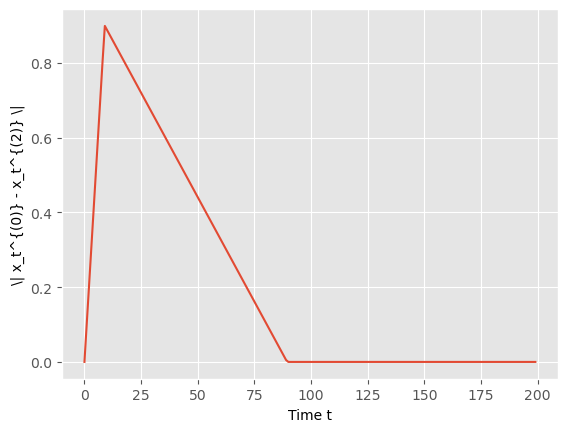

In [64]:
plt.plot(l_diff)
plt.xlabel('Time t')
plt.ylabel('\| x_t^{(0)} - x_t^{(2)} \|')
plt.show()

In [66]:
logging.info(f'Decisions for mode 0: {[res.x for res in l_ftrl_res[0][:]]}')
logging.info(f'Decisions for mode 2: {[res.x for res in l_ftrl_res[2][:]]}')

06:46:49 PM 3614189879.py:1 Decisions for mode 0: [-5.486160730118299e-09, -0.011180344010648555, -0.02236068445115084, -0.033541023140749, -0.044721363777205925, -0.05590170408745911, -0.06708204278005232, -0.07826238172788909, -0.08944272334780341, -0.10062306620519075, -0.11180340236109654, -0.12298374089131703, -0.13416408233489102, -0.1453444271486489, -0.15652475896003124, -0.16770510018763746, -0.1788854432594932, -0.19006577784748524, -0.20124611709263215, -0.21242645528083576, -0.2236067971589632, -0.23478713239131238, -0.24596747325463325, -0.2571478159067816, -0.2683281571271441, -0.27950849241716014, -0.29068883265834616, -0.301869205075542, -0.31304951370402867, -0.32422985817457217, -0.33541018964597086, -0.3465905242749215, -0.3577708693044123, -0.3689512001668539, -0.3801315423725301, -0.39131176673839324, -0.4024922169114161, -0.41367256836405736, -0.42485289008358523, -0.43603324495627876, -0.44721356613124064, -0.45839394186448035, -0.46957425453697316, -0.4807546084